In [1]:
# https://www.youtube.com/watch?v=YUOSoCw5mRQ
# https://www.youtube.com/watch?v=L5litdBc8P4
# https://www.youtube.com/watch?v=Ve_4oC1kjEQ

In [2]:

import cv2
import numpy as np
from PIL import Image
import io
import os
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq

def compress_frame(frame, quality=85):
    """Compress an image frame using JPEG compression."""
    img = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    buffer = io.BytesIO()
    img.save(buffer, format="JPEG", quality=quality)
    return buffer.getvalue()

def extract_and_compress_video_to_parquet(video_path, compression_quality=85):
    """Extract frames from a video, compress them, and return as a list of tuples."""
    # Initialize video capture
    cap = cv2.VideoCapture(video_path)
    frames_data = []

    # Frame index
    frame_idx = 0

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        
        # Compress the frame
        compressed_frame = compress_frame(frame, quality=compression_quality)
        
        # Append frame index and compressed frame to list
        frames_data.append((frame_idx, compressed_frame))
        
        # Increment frame index
        frame_idx += 1

        if frame_idx % (60 * 30 * 5) == 0:
            print("Minutes captured assuming 30 fps:", frame_idx / (60 * 30))

    # Release the video capture
    cap.release()

    return frames_data

def process_videos_in_directory(directory_path, parquet_path, compression_quality=85):
    """Process all videos in the directory starting with 'Minecraft' and save frames to a single parquet."""
    all_frames_data = []

    # Loop through all files in the directory
    for filename in os.listdir(directory_path):
        if filename.endswith(".mp4") and filename.startswith("Minecraft"):
            video_path = os.path.join(directory_path, filename)
            print(f"Processing video: {video_path}")
            
            # Extract frames and compress
            frames_data = extract_and_compress_video_to_parquet(video_path, compression_quality)
            all_frames_data.extend(frames_data)
    
    # Create DataFrame from all frames
    df = pd.DataFrame(all_frames_data, columns=['index', 'compressed_frame'])

    # Save to parquet
    df.to_parquet(parquet_path, engine='pyarrow', compression='snappy')
    print(f"All videos processed and saved to {parquet_path}")

# Path to the directory containing videos and the output parquet file
directory_path = "./videos"
parquet_path = "Minecraft_all_videos_frames.parquet"
if recapture_video := False:

    # Process videos and save to a parquet file
    process_videos_in_directory(directory_path, parquet_path)


In [3]:
frameDF = pd.read_parquet(parquet_path)

In [4]:
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch
from torchvision.transforms.v2 import Resize
import einx


class FrameDataset(Dataset):
    def __init__(self, frameDF):
        self.frameDF = frameDF
    def __len__(self):
        return self.frameDF.shape[0]
    def __getitem__(self, idx):
        row = self.frameDF.iloc[idx] 
        compressed_frame = row['compressed_frame']
        img = Image.open(io.BytesIO(compressed_frame))
        frame = np.array(img)
        frame = torch.tensor(frame)
        frame = einx.rearrange("h w c -> c h w", frame)
        resizer = Resize((176, 320))
        frame = resizer(frame)
        frame = einx.rearrange("c (h h16) (w w16) -> (h w) (h16 w16 c)", frame, h16=16, w16=16)
        return frame.float() / 255
        
frameDataset = FrameDataset(frameDF)
frameLoader = DataLoader(frameDataset, batch_size=16, shuffle=True)

In [5]:
import matplotlib.pyplot as plt

frameDataset[800].shape

torch.Size([220, 768])

In [6]:
from models.Autoencoder import MaskedAutoencoder
inpDimension = 768
embDim = 16
encoderNumHeads = 1
encoderNumBlocks = 1
decoderNumHeads = 1
decoderNumBlocks = 1
maskingRatio = 0.75

model = MaskedAutoencoder(inpDimension, embDim, encoderNumHeads, encoderNumBlocks, decoderNumHeads, decoderNumBlocks).cuda()

sampleBatch = next(iter(frameLoader))
maskedInputTensor, maskedDecodedOutput,unscrambledStitchedInpViz, unscrambledStitchedImageBatch = model(sampleBatch.cuda())

In [7]:
from torch.utils.data import Subset
from sklearn.model_selection import train_test_split

trainIdxs, testIdxs = train_test_split(range(len(frameDataset)), train_size = 0.9)
trainSubset = Subset(frameDataset, trainIdxs)
print(len(trainSubset))
trainLoader = DataLoader(trainSubset, batch_size=64, shuffle=True)
testSubset = Subset(frameDataset, testIdxs)
testLoader = DataLoader(testSubset, batch_size=64, shuffle=False)

125615


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.07967402..0.95204455].


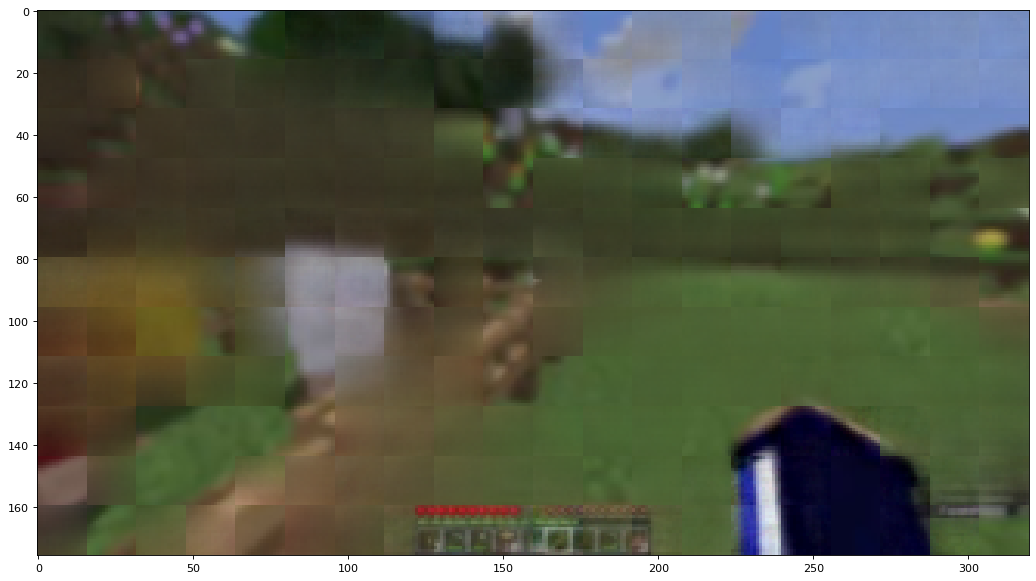

In [11]:
from matplotlib.pyplot import figure


def getPlottableImage(chunkedUpImage):
    frame = einx.rearrange("(h w) (h16 w16 c) -> (h h16) (w w16) c", chunkedUpImage, h16=16, w16=16, h=176 // 16)
    return frame

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


inpDimension = 768
embDim = 768
encoderNumHeads = 12
encoderNumBlocks = 10
decoderNumHeads = 8
decoderNumBlocks = 1
maskingRatio = 0.75
model = MaskedAutoencoder(inpDimension, embDim, encoderNumHeads, encoderNumBlocks, decoderNumHeads, decoderNumBlocks).to(device)
model.load_state_dict(torch.load("models/PretrainedAutoencoder.pt"))

maskedInputTensor, maskedDecodedOutput,unscrambledStitchedInpViz, unscrambledStitchedImageBatch = model(next(iter(trainLoader)).cuda())

figure(figsize=(16, 12), dpi=80)
plt.imshow(getPlottableImage(unscrambledStitchedImageBatch[0]).cpu().detach().numpy())

In [ ]:
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR
from tqdm import tqdm


epochs = 100
learningRate = 3e-5

optimizer = AdamW(model.parameters(), lr = learningRate)
scheduler = CosineAnnealingLR(optimizer, epochs)
criterion = nn.MSELoss()


for epoch in range(epochs):
    running_loss = 0
    for idx, frameBatch in enumerate(tqdm(trainLoader)):
        model.zero_grad()
        frameBatch = frameBatch.to(device)
        maskedInputTensor, maskedDecodedOutput, _, unscrambledImageBatch = model(frameBatch)

        loss = criterion(maskedDecodedOutput, maskedInputTensor)
        running_loss += loss.item() * frameBatch.shape[0]
        
        loss.backward()
        optimizer.step()
        

    running_test_loss = 0
    for idx, frameBatch in enumerate(tqdm(testLoader)):
        with torch.no_grad():
            frameBatch = frameBatch.to(device)
            maskedInputTensor, maskedDecodedOutput, _, unscrambledImageBatch = model(frameBatch)
    
            loss = criterion(maskedDecodedOutput, maskedInputTensor)
            
            running_test_loss += loss.item() * frameBatch.shape[0]

    print(f"Epoch {epoch + 1} / {epochs:<5}: Train Loss: {round((running_loss / len(trainSubset)) ** 0.5 * 255, 3):<8} Test Loss: {round((running_test_loss / len(testSubset)) ** 0.5 * 255, 3):<8}")

    scheduler.step()


In [10]:
torch.save(model.state_dict(), "models/PretrainedAutoencoder.pt")

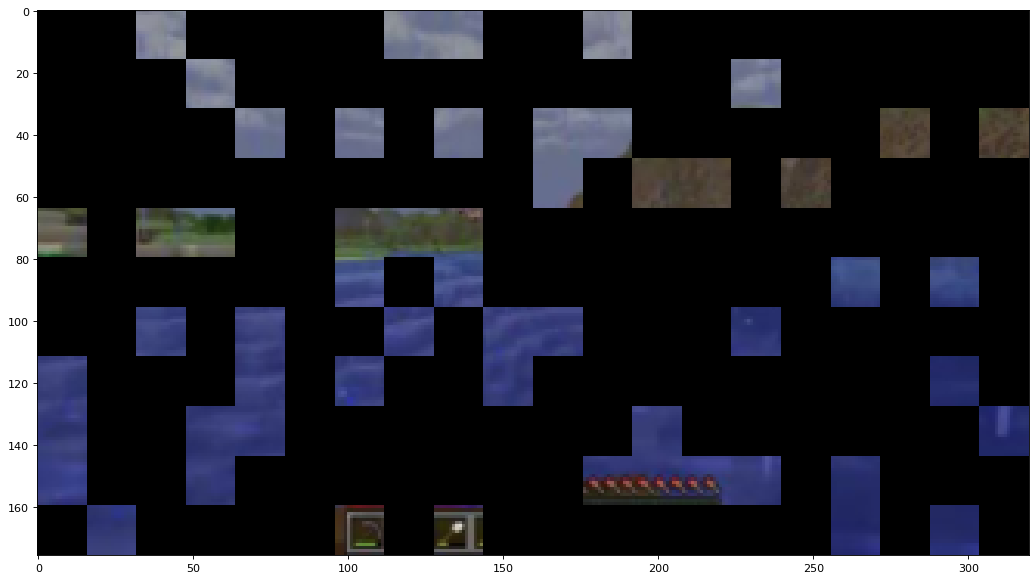

In [20]:
import random
# 12870 is a good demo idx
# 4011 is a good demo idx
# 4328 learned what a sheep is,m did not learn what a red sheep is
# 7718 learned nice interpolation, shapes
imgSet = testSubset

randIdx = random.choice(range(len(imgSet)))
#randIdx = 4328
sampleBatch = imgSet[randIdx].unsqueeze(0)

sampleBatch = sampleBatch.to(device)
maskedInputTensor, maskedDecodedOutput, inputToDecoderBatch, unscrambledImageBatch = model(sampleBatch, 0.75)
plottableFrame = getPlottableImage(inputToDecoderBatch[0])

figure(figsize=(16, 12), dpi=80)

plt.imshow(plottableFrame.cpu().detach().numpy())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.023722038..0.97430223].


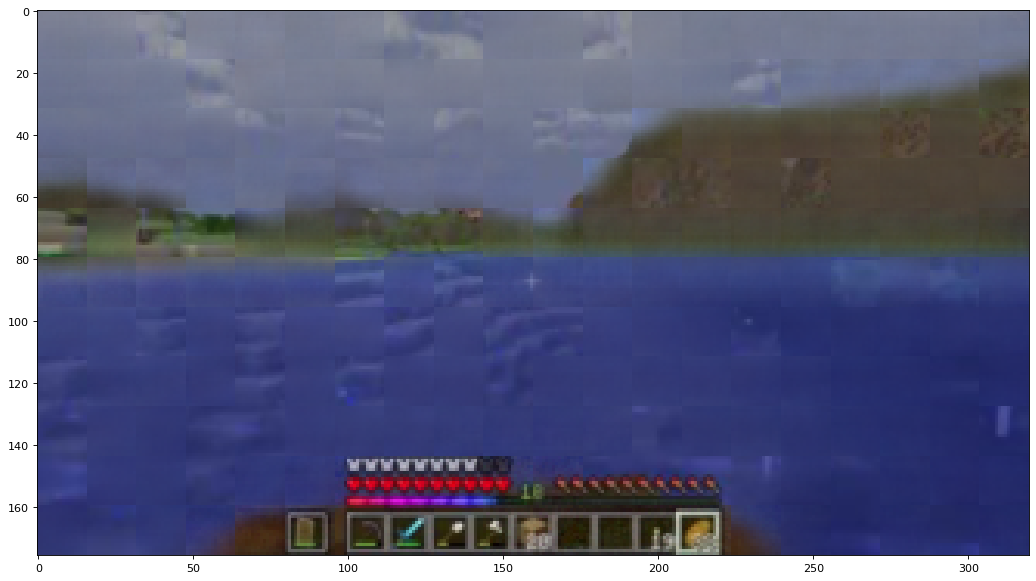

In [21]:
plottableFrame = getPlottableImage(unscrambledImageBatch[0])

figure(figsize=(16, 12), dpi=80)

plt.imshow(plottableFrame.cpu().detach().numpy())

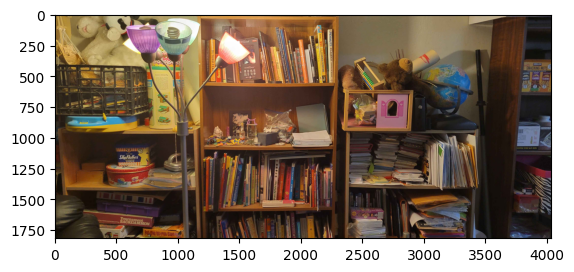

In [132]:
def processIm(PILImage):
    frame = np.array(PILImage)
    frame = torch.tensor(frame)
    frame = einx.rearrange("h w c -> c h w", frame)
    resizer = Resize((176, 320))
    frame = resizer(frame)
    frame = einx.rearrange("c (h h16) (w w16) -> (h w) (h16 w16 c)", frame, h16=16, w16=16)
    return frame.float() / 255

im = Image.open("NewImages/Bookshelf.jpg")
processedIm = processIm(im)
processedIm = processedIm.unsqueeze(0).cuda()
maskedInputTensor, maskedDecodedOutput, inputToDecoderBatch, unscrambledImageBatch = model(processedIm)
plt.imshow(im)

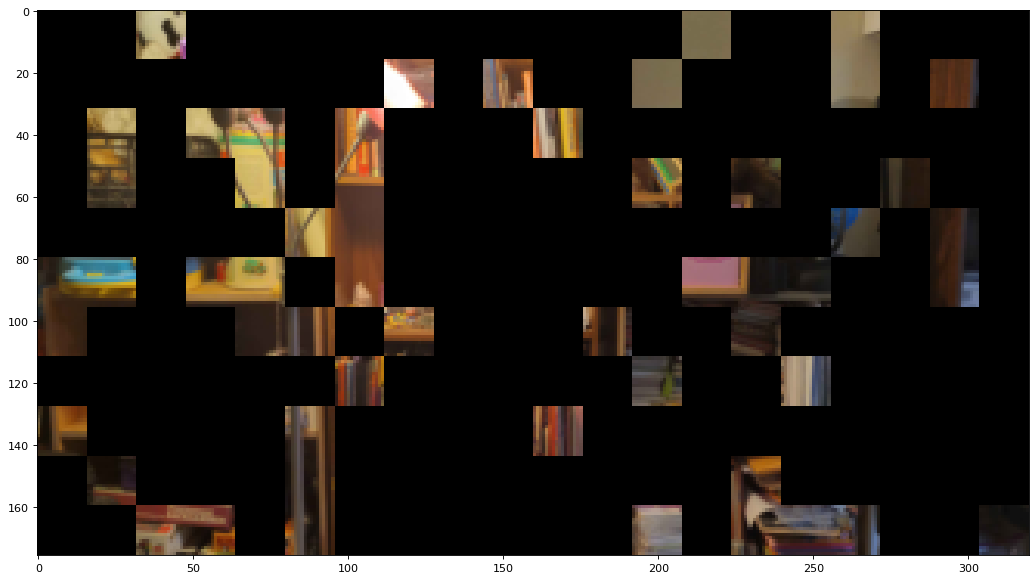

In [133]:
plottableFrame = getPlottableImage(inputToDecoderBatch[0])
figure(figsize=(16, 12), dpi=80)

plt.imshow(plottableFrame.cpu().detach().numpy())

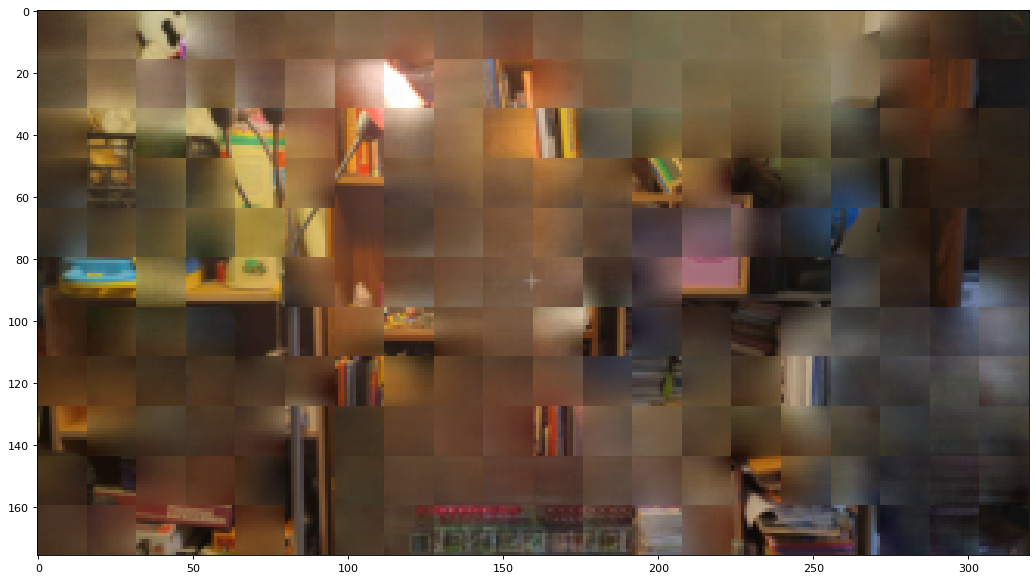

In [134]:
plottableFrame = getPlottableImage(unscrambledImageBatch[0])
figure(figsize=(16, 12), dpi=80)

plottableFrame[plottableFrame > 1] = 1.0
plottableFrame[plottableFrame < 0] = 0

plt.imshow(plottableFrame.cpu().detach().numpy())